### About this Notebook 
This notebook uses Convolutional Neural Network to recognize hand-written digits. 

### Author 
This notebook was written by Mohammed Alhamid

### Objective 
Creating fully-dense Convolutional Neural Net using Keras to recognize hand-written digits provided by MNIST database. 

![digits.png](images/digits.png)

### Main libraries used 

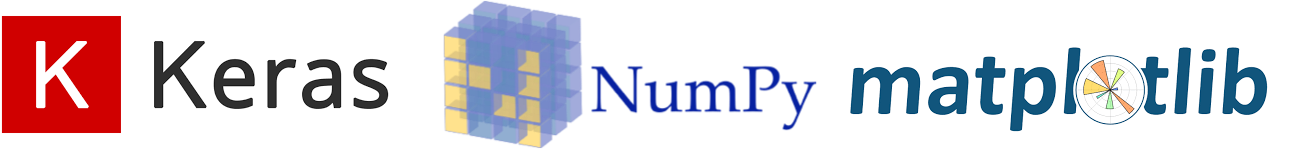

In [1]:
# Importing MNIST library from Keras
from keras.datasets import mnist
# Importing Matplotlib for visualization 
from matplotlib import pyplot
import matplotlib.pyplot as plt
# Importing Numpy library 
import numpy as np
import keras 

%matplotlib inline

Using TensorFlow backend.
/Users/mohammedalhamid/anaconda3/envs/py37/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/mohammedalhamid/anaconda3/envs/py37/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/mohammedalhamid/anaconda3/envs/py37/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1

### Loading the dataset

In [2]:
def load_dataset():
    (X_train, y_train), (X_test, y_test) = mnist.load_data()
    return X_train, y_train, X_test, y_test

In [3]:
X_train, y_train, X_test, y_test = load_dataset()

In [4]:
#Explore the content of the dataset 
print('The number of images in the training dataset=', X_train.shape[0])
print('The number of images in the test dataset', X_test.shape[0])

The number of images in the training dataset= 60000
The number of images in the test dataset 10000


In [5]:
#The shape of images
X_train.shape

(60000, 28, 28)

In [6]:
#The shape of labels
y_train.shape

(60000,)

### Visualize some example from the dataset

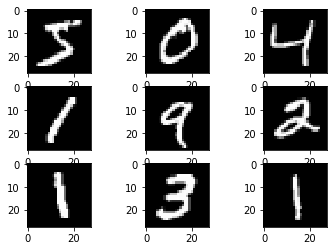

In [7]:
# Let us visualize 12 examples: 
for i in range(9):
    # set the subplot
    pyplot.subplot(330 + 1 + i)
    # plot image pixesles
    pyplot.imshow(X_train[i], cmap=pyplot.get_cmap('gray'))
    
# Display the image
pyplot.show()

<function matplotlib.pyplot.show(*args, **kw)>

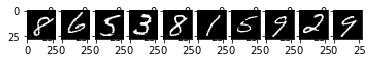

In [8]:
#Display last images
fig, ax = plt.subplots(1, 10)
for i in range(10):
    ax[i].imshow(X_train[X_train.shape[0]-1-i], cmap="gray")
plt.show

In [9]:
# Explore the contents of the target labels 
y_train

array([5, 0, 4, ..., 5, 6, 8], dtype=uint8)

# Preprocessing Training data

In [10]:
# Record the number of unique values 
print('Number of unique values', len(np.unique(y_train)))
print(np.unique(y_train))

Number of unique values 10
[0 1 2 3 4 5 6 7 8 9]


In [11]:
def process_images(X_train, X_test):
    img_x, img_y = X_train.shape[1], X_train.shape[2]
    # Reshaping the images
    X_train = X_train.reshape(X_train.shape[0], img_x, img_y, 1)
    X_test =  X_test.reshape(X_test.shape[0], img_x, img_y, 1)
    
    X_train = X_train.astype('float32')
    X_test = X_test.astype('float32')
    
    X_train /= 255
    X_test /= 255
    input_shape = (img_x, img_y, 1)
    return X_train, X_test, input_shape

In [12]:
X_train, X_test, input_shape = process_images(X_train, X_test)

In [13]:
print('Shape of X_train', X_train.shape)
print('Shape of X_test', X_test.shape)
print('Shape of y_train', y_train.shape)
print('Shape of y_test', y_test.shape)

Shape of X_train (60000, 28, 28, 1)
Shape of X_test (10000, 28, 28, 1)
Shape of y_train (60000,)
Shape of y_test (10000,)


# Preprocessing the labels 

In [14]:
# The number of classes is equal to 10, which represents the unique values of the vestor y_train and y_test
num_classes = 10

In [15]:
# We need first to one-hot encode the labels, this will speed up the training
y_train = keras.utils.to_categorical(y_train, num_classes)

In [16]:
#Similar encoding for the testing data
y_test = keras.utils.to_categorical(y_test, num_classes)

In [17]:
y_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.]], dtype=float32)

In [18]:
# Displaying the shape of the training label vector 
y_train.shape

(60000, 10)

In [19]:
# Displaying the shape of the testing label vector 
y_test.shape

(10000, 10)

# Building the CNN model

In [20]:
# To facilitate the building of the CNN models in different architecture, we will define the following function
#Parameters:
# batch_size: the size of the batch 
# epochs: number of epochs 
# input_shape: The input shape of the images
# w_size: The size of the feature detector (kernel window)
# p_size: The size of the pooling matrix
# n_c_layer: The number of convolutional layers
# n_d_layer: The number of dense layers 
# transfer_actfun: the transfer function for the hidden layers
# output_actfun: the output activation function
# dropout : An array that has the number of dropout layer and percentage 
# batch_nor: Boolean True/False
def build_model(batch_size, epochs, input_shape, w_size, p_size, n_c_layer, n_d_layer ,transfer_actfun, output_actfun, dropout, batch_nor): 
    # First step is creating the Neural Network model 
    model = Sequential()
    # Adding the convolution layer with 32 nuerons and 5 x 5 feature detector (size of the kernel window)
    for _ in range(n_c_layer):
        model.add(Conv2D(32, kernel_size=(w_size, w_size),
                     activation=transfer_actfun,
                     input_shape=input_shape))
    if batch_nor: 
        # Adding batch normalization
        model.add(BatchNormalization())
    #Adding the pool layer to choose the best features in size of 2x2 matrix 
    model.add(MaxPooling2D(pool_size=(p_size, p_size)))
    #Adding dropout layer if given in the parameters
    for i in range(len(dropout)): 
        model.add(Dropout(dropout[i]))
    #Next, we need to flatten the dimensions since we only have 10 classificiation outputs 
    model.add(Flatten())
    #Adding some dense layers if required: 
    for _ in range(n_d_layer): 
        model.add(Dense(128, activation='relu'))
    #Adding the output layer with softmax to produce the required output probabilities
    model.add(Dense(num_classes, activation=output_actfun))
    return model

In [21]:
# This function will be used to plot the history of the model training
def display_history(history): 
    # plotting the model accuracy and model learning lost
    fig = plt.figure()
    plt.subplot(2,1,1)
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='lower right')

    plt.subplot(2,1,2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper right')

    plt.tight_layout()

    return fig

## Model1: Building a single layer CNN

In [22]:
import keras
from keras.models import Sequential
# We need tom import few libaries from keras.layers to build up the CNN models 
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization

In [23]:
#Defining the model parameters 
batch_size = 128
epochs = 5

In [24]:
# Buidling the first model with the following parameters: 
# batch_size = 128 
# epochs = 5 
# the size of feature detector 5 x 5
# the size of pooling matrix 2 x 2
# One convolutional layer 
# One Output dense layer 
# No dropout 
# No batch normalization
model = build_model(batch_size, epochs, input_shape, 5, 2, 1, 0,'sigmoid' ,'softmax', [], False)

Instructions for updating:
Colocations handled automatically by placer.


In [25]:
# Compiling the model 
model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics='accuracy'.split())

In [26]:
#Validating the model structure 
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 24, 24, 32)        832       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 4608)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                46090     
Total params: 46,922
Trainable params: 46,922
Non-trainable params: 0
_________________________________________________________________


In [27]:
%%time
#Training the model
history = model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=2,
          validation_data=(X_test, y_test))

Instructions for updating:
Use tf.cast instead.
Train on 60000 samples, validate on 10000 samples
Epoch 1/5
 - 7s - loss: 2.1707 - acc: 0.2337 - val_loss: 1.7631 - val_acc: 0.4712
Epoch 2/5
 - 7s - loss: 1.2282 - acc: 0.7004 - val_loss: 0.8211 - val_acc: 0.8177
Epoch 3/5
 - 7s - loss: 0.7017 - acc: 0.8228 - val_loss: 0.5874 - val_acc: 0.8418
Epoch 4/5
 - 7s - loss: 0.5447 - acc: 0.8561 - val_loss: 0.4923 - val_acc: 0.8701
Epoch 5/5
 - 7s - loss: 0.4769 - acc: 0.8704 - val_loss: 0.4296 - val_acc: 0.8822
CPU times: user 4min 51s, sys: 22.9 s, total: 5min 14s
Wall time: 35.2 s


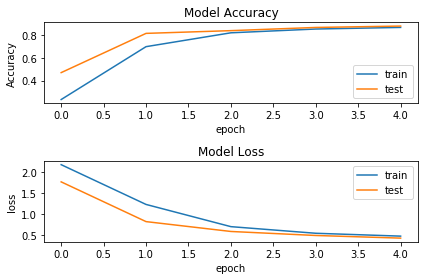

In [28]:
fig = display_history(history)

In [29]:
# Get the evaluation of the testing dataset 
m1_results = model.evaluate(X_test,y_test)

10000/10000 [==============================] - 1s 100us/step


In [30]:
print('Lost =', m1_results[0] ,'  Accuracy =', m1_results[1])

Lost = 0.4296308158397675   Accuracy = 0.8822


## Model 2, building more dense architecture 

Let us add more complexity to the CNN model: 

Hypothesis, it will increase the accuracy of the model but the training time would increase. 

In [31]:
#Add one more convolutional layer with 32 neurons (feature maps) and a 5x5 feature detector. 
# parameters: 
# batch_size = 128 
# epochs = 5 
# the size of feature detector 5 x 5
# the size of pooling matrix 2 x 2
# One convolutional layer 
# One Dense layer
# One Output dense layer
# No dropout 
# No batch normalization
model2 = build_model(batch_size, epochs, input_shape, 5, 2, 2, 1,'sigmoid' ,'softmax', [], False)

In [32]:
# Compiling the model 
model2.compile(loss='categorical_crossentropy', optimizer='sgd', metrics='accuracy'.split())

In [33]:
#Validating the model structure 
model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 24, 24, 32)        832       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 20, 20, 32)        25632     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 10, 10, 32)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 3200)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               409728    
_________________________________________________________________
dense_3 (Dense)              (None, 10)                1290      
Total params: 437,482
Trainable params: 437,482
Non-trainable params: 0
_________________________________________________________________


In [34]:
#Training the model 
model2.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=2,
          validation_data=(X_test, y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/5
 - 43s - loss: 2.3071 - acc: 0.1126 - val_loss: 2.3021 - val_acc: 0.1028
Epoch 2/5
 - 44s - loss: 2.2809 - acc: 0.1442 - val_loss: 2.2424 - val_acc: 0.2845
Epoch 3/5
 - 41s - loss: 1.9160 - acc: 0.4393 - val_loss: 1.2099 - val_acc: 0.6615
Epoch 4/5
 - 42s - loss: 0.7470 - acc: 0.7968 - val_loss: 0.5173 - val_acc: 0.8547
Epoch 5/5
 - 43s - loss: 0.4747 - acc: 0.8630 - val_loss: 0.4126 - val_acc: 0.8796


In [35]:
# Get the evaluation of the testing dataset 
m2_results = model2.evaluate(X_test,y_test)

10000/10000 [==============================] - 3s 340us/step


In [36]:
print('Lost =', m2_results[0] ,'  Accuracy =', m2_results[1])

Lost = 0.4125865311384201   Accuracy = 0.8796


##### -- Findings -- <br>
The results accuracy using the second model did not go up as we were expecting. 
In fact, the first model is slightly more accurate and faster to train. One thing came to out mind is the number of node in the hidden layer is not enough to extrapolite the convolution

## Adding Dropout Layer

In this taks, we are going to examine the effects of adding a dropout layer

Hypothesis, it will avoid overfitting the data and hence perform well on the test data. May increase the training time 

In [37]:
model3 = build_model(batch_size, epochs, input_shape, 5, 2, 2, 1,'sigmoid' ,'softmax', [0.25], False)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [38]:
# Compiling the model 
model3.compile(loss='categorical_crossentropy', optimizer='sgd', metrics='accuracy'.split())

In [39]:
#Validating the model structure 
model3.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 24, 24, 32)        832       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 20, 20, 32)        25632     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 10, 10, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 10, 10, 32)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 3200)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               409728    
_________________________________________________________________
dense_5 (Dense)              (None, 10)                1290      
Total para

In [40]:
#Training the model 
model3.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=2,
          validation_data=(X_test, y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/5
 - 44s - loss: 2.3151 - acc: 0.1060 - val_loss: 2.2987 - val_acc: 0.1135
Epoch 2/5
 - 47s - loss: 2.3021 - acc: 0.1101 - val_loss: 2.2993 - val_acc: 0.0958
Epoch 3/5
 - 44s - loss: 2.2998 - acc: 0.1140 - val_loss: 2.2946 - val_acc: 0.2009
Epoch 4/5
 - 45s - loss: 2.2931 - acc: 0.1284 - val_loss: 2.2779 - val_acc: 0.1010
Epoch 5/5
 - 44s - loss: 2.2301 - acc: 0.2093 - val_loss: 2.0517 - val_acc: 0.4677


In [41]:
# Get the evaluation of the testing dataset 
m3_results = model3.evaluate(X_test,y_test)

10000/10000 [==============================] - 4s 366us/step


In [42]:
print('Lost =', m3_results[0] ,'  Accuracy =', m3_results[1])

Lost = 2.0517194766998292   Accuracy = 0.4677


##### -- Findings -- <br>
The results accuracy using the third model got extremley worst. 

### Part 2, Task 4

In this taks, we are going to add a dropout layer

Hypothesis, adding batch normalization will make the model train much faster and converge much more quickly

In [43]:
model4 = build_model(batch_size, epochs, input_shape, 5, 2, 2, 1,'sigmoid' ,'softmax', [0.25], True)

In [44]:
# Compiling the model 
model4.compile(loss='categorical_crossentropy', optimizer='sgd', metrics='accuracy'.split())

In [45]:
model3.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 24, 24, 32)        832       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 20, 20, 32)        25632     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 10, 10, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 10, 10, 32)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 3200)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               409728    
_________________________________________________________________
dense_5 (Dense)              (None, 10)                1290      
Total para

In [46]:
#Training the model 
model4.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=2,
          validation_data=(X_test, y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/5
 - 58s - loss: 0.5625 - acc: 0.8367 - val_loss: 0.2617 - val_acc: 0.9185
Epoch 2/5
 - 58s - loss: 0.2474 - acc: 0.9262 - val_loss: 0.1858 - val_acc: 0.9437
Epoch 3/5
 - 57s - loss: 0.1923 - acc: 0.9428 - val_loss: 0.1552 - val_acc: 0.9533
Epoch 4/5
 - 56s - loss: 0.1579 - acc: 0.9527 - val_loss: 0.1228 - val_acc: 0.9623
Epoch 5/5
 - 56s - loss: 0.1376 - acc: 0.9592 - val_loss: 0.1110 - val_acc: 0.9662


In [47]:
# Get the evaluation of the testing dataset 
m4_results = model4.evaluate(X_test,y_test)

10000/10000 [==============================] - 4s 403us/step


In [48]:
print('Lost =', m4_results[0] ,'  Accuracy =', m4_results[1])

Lost = 0.11102580700442195   Accuracy = 0.9662


##### -- Findings -- <br>
The results improved significantly 

## What to consider to improve the model accuracy

We could do the following: 
- Decreasing the pool window size (kernel size) to increase the sensitivity of the detection
- Change the activation function 
- Adding a dropout layer after the dense layer 
- Increasing the number of epochs, increase the model training time but we trying to compromise that to increase accuracy 
- Change the optimization function. ReLu is nonlinear in nature. It might be a good approximator in this situation


## Improving the model performance 

In [49]:
# To facilitate the building of the CNN models in different architecture, we will define the following function
#Parameters:
# batch_size: the size of the batch 
# epochs: number of epochs 
# input_shape: The input shape of the images
# w_size: The size of the feature detector (kernel window)
# p_size: The size of the pooling matrix
# n_c_layer: The number of convolutional layers
# n_d_layer: The number of dense layers 
# transfer_actfun: the transfer function for the hidden layers
# output_actfun: the output activation function
# dropout : An array that has the number of dropout layer and percentage 
# batch_nor: Boolean True/False
def build_model_v2(batch_size, epochs, input_shape, w_size, p_size, n_c_layer, n_d_layer ,transfer_actfun, output_actfun, dropout, batch_nor): 
    # First step is creating the Neural Network model 
    model = Sequential()
    # Adding the convolution layer with 32 nuerons and 5 x 5 feature detector (size of the kernel window)
    for i in range(n_c_layer):
        model.add(Conv2D(32 *( i + 1), kernel_size=(w_size, w_size),
                     activation=transfer_actfun,
                     input_shape=input_shape))
    if batch_nor: 
        # Adding batch normalization
        model.add(BatchNormalization())
    #Adding the pool layer to choose the best features in size of 2x2 matrix 
    model.add(MaxPooling2D(pool_size=(p_size, p_size)))
    #Adding dropout layer if given in the parameters
    for i in range(len(dropout)): 
        model.add(Dropout(dropout[i]))
    #Next, we need to flatten the dimensions since we only have 10 classificiation outputs 
    model.add(Flatten())
    #Adding some dense layers if required: 
    for _ in range(n_d_layer): 
        model.add(Dense(128, activation=transfer_actfun))
    model.add(Dropout(0.5))
    #Adding the output layer with softmax to produce the required output probabilities
    model.add(Dense(num_classes, activation=output_actfun))
    return model

In [50]:
model5 = build_model_v2(batch_size, epochs, input_shape, 3, 2, 2, 1,'relu' ,'softmax', [0.25], False)

In [51]:
model5.compile(loss='categorical_crossentropy', optimizer='Adadelta', metrics='accuracy'.split())

In [52]:
model5.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 12, 12, 64)        0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 9216)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 128)               1179776   
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)               0         
__________

In [53]:
#Training the model 
history = model5.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=10,
          verbose=2,
          validation_data=(X_test, y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
 - 47s - loss: 0.2613 - acc: 0.9188 - val_loss: 0.0543 - val_acc: 0.9831
Epoch 2/10
 - 46s - loss: 0.0863 - acc: 0.9736 - val_loss: 0.0385 - val_acc: 0.9862
Epoch 3/10
 - 49s - loss: 0.0663 - acc: 0.9806 - val_loss: 0.0364 - val_acc: 0.9872
Epoch 4/10
 - 48s - loss: 0.0531 - acc: 0.9835 - val_loss: 0.0330 - val_acc: 0.9890
Epoch 5/10
 - 48s - loss: 0.0455 - acc: 0.9860 - val_loss: 0.0304 - val_acc: 0.9899
Epoch 6/10
 - 47s - loss: 0.0407 - acc: 0.9874 - val_loss: 0.0304 - val_acc: 0.9898
Epoch 7/10
 - 47s - loss: 0.0367 - acc: 0.9884 - val_loss: 0.0275 - val_acc: 0.9903
Epoch 8/10
 - 45s - loss: 0.0333 - acc: 0.9896 - val_loss: 0.0295 - val_acc: 0.9910
Epoch 9/10
 - 45s - loss: 0.0315 - acc: 0.9906 - val_loss: 0.0293 - val_acc: 0.9910
Epoch 10/10
 - 45s - loss: 0.0289 - acc: 0.9910 - val_loss: 0.0292 - val_acc: 0.9916


In [54]:
m5_results = model5.evaluate(X_test,y_test)

10000/10000 [==============================] - 3s 283us/step


In [55]:
print('Lost =', m5_results[0] ,'  Accuracy =', m5_results[1])

Lost = 0.029154129273346006   Accuracy = 0.9916


# Summary and Comparisons

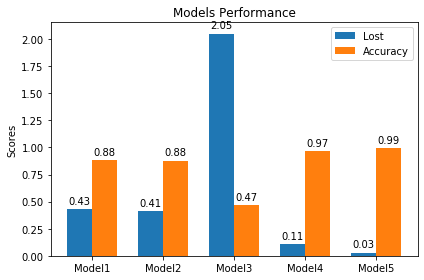

In [56]:
labels = ['Model1', 'Model2', 'Model3', 'Model4', 'Model5']
men_means = [m1_results[0],m2_results[0],m3_results[0],m4_results[0],m5_results[0]]
women_means = [m1_results[1],m2_results[1],m3_results[1],m4_results[1],m5_results[1]]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
bar1 = ax.bar(x - width/2, men_means, width, label='Lost')
bar2 = ax.bar(x + width/2, women_means, width, label='Accuracy')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('Models Performance')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

def autolabel(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate('{}'.format(round(height, 2)),
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(bar1)
autolabel(bar2)

fig.tight_layout()
plt.show()

The best accuracy achieved is 99% using Model 5.

#### Investigating Model 5 Learning Rate 

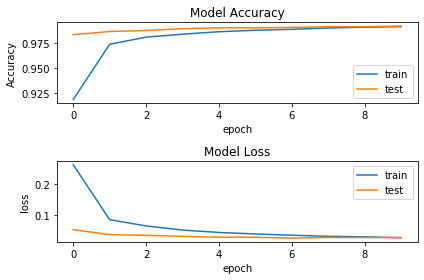

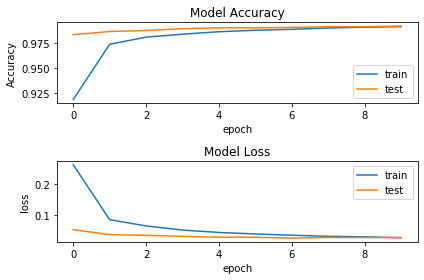

In [57]:
# plotting the model accuracy and model learning lost
fig = plt.figure()
plt.subplot(2,1,1)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')

plt.subplot(2,1,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')

plt.tight_layout()

fig